In [25]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
# List of experiments, with chunk type, chunk size.
list_chunks = [
('words', 50),
('words', 300),
('words', 500),
('sentences', 10),
('sentences', 50),
('sentences', 100),
('paragraphs', 1),
('paragraphs', 5),
('paragraphs', 10),
('paragraphs', 15),
('pages', 1)
]

In [26]:
k_list = [2, 5, 10, 15]


In [27]:
# loading the metrics from the json files
list_vals = []
for TOP_K in k_list:
    for CHUNK_TYPE, CHUNK_SIZE in list_chunks:
        metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
        #print(metrics_filename)
        metrics = json.load(open(metrics_filename))
        toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

        # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
        dict_metrics = metrics['full_dataset']['full_dataset']
        toAdd |= dict_metrics
        list_vals.append(toAdd)

In [28]:
df = pd.DataFrame(list_vals)

In [39]:
df_rfp.head()

,k,chunk_type,chunk_size,rfp_id,answer_relevancy,faithfulness,context_recall,context_precision,answer_correctness,EM,F1,avg_retrieve_context,avg_llm_response,avg_total,sample_size
0,2,words,50,infra_1,0.635032,0.865079,0.596825,0.857143,0.563162,0.000000,0.271523,0.058654,1.366676,1.425330,21
1,2,words,50,infra_2,0.716019,0.737179,0.923077,0.884615,0.664090,0.076923,0.551371,0.058654,1.424742,1.483396,13
2,2,words,50,infra_3,0.543461,0.763889,0.625000,0.750000,0.570266,0.000000,0.326104,0.058654,0.684769,0.743423,12
3,2,words,50,infra_4,0.538354,0.744048,0.491071,0.928571,0.444594,0.000000,0.306448,0.058654,1.215387,1.274041,14
4,2,words,50,natsec_1,0.440090,0.666667,0.500000,0.666667,0.556234,0.000000,0.196523,0.058654,0.641381,0.700035,6


Code for getting bubble heatmap:
1. get the data read in for each rfp type + k, chunk_type, chunk_size, etc
2. calc std
3. add that to the df
4. get bubble heatmap


In [38]:
# loading the metrics from the json files
list_vals = []
for TOP_K in k_list:
    for CHUNK_TYPE, CHUNK_SIZE in list_chunks:
        metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
        #print(metrics_filename)
        metrics = json.load(open(metrics_filename))
        #toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

        # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
        rfps = metrics['RFP_id']
        for rfp in rfps.keys():
            toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "rfp_id": rfp}
            dict_metrics = rfps[rfp]
            toAdd |= dict_metrics
            list_vals.append(toAdd)
df_rfp = pd.DataFrame(list_vals)

In [40]:
list_metrics = ["answer_relevancy","faithfulness", 'context_recall','context_precision', 
                'answer_correctness', 'EM', 'F1',
                'avg_retrieve_context', 'avg_llm_response', 'avg_total', 'sample_size']

df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()
df_final = pd.merge(df, df_grouped, on = ['k', 'chunk_type', 'chunk_size'], how='left', suffixes=('', '_std'))

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/2623827307.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()


In [68]:
def std_scatterplot(df_final, metric = "faithfulness"):
    metric_std = metric + "_std"
    toPlot = df_final[["k", "chunk_type", "chunk_size", metric, metric_std]]
    toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)
    ax = sns.scatterplot(
        data=toPlot,
        x="chunk",
        y="k",
        size=metric_std,
        hue = metric,
        sizes=(20, 2000),
        palette = "crest"
    )
    ax.set_title(metric)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # show the graph
    plt.xticks(rotation=45, ha='right') 
    plt.show()

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


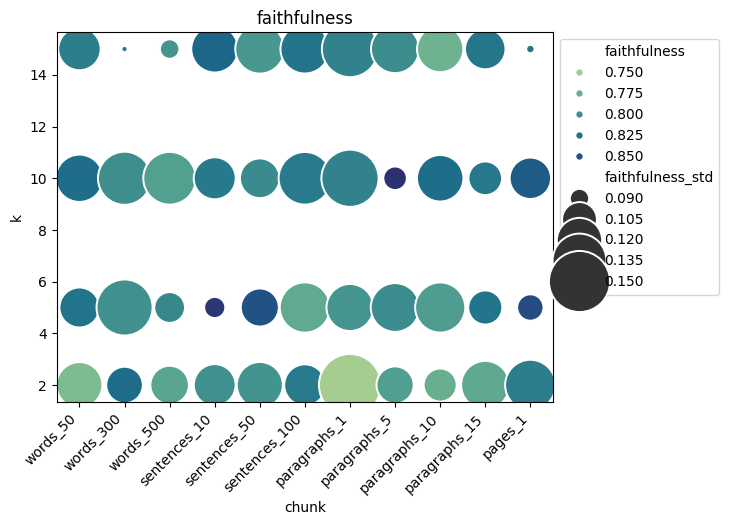

In [69]:
std_scatterplot(df_final,"faithfulness")

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


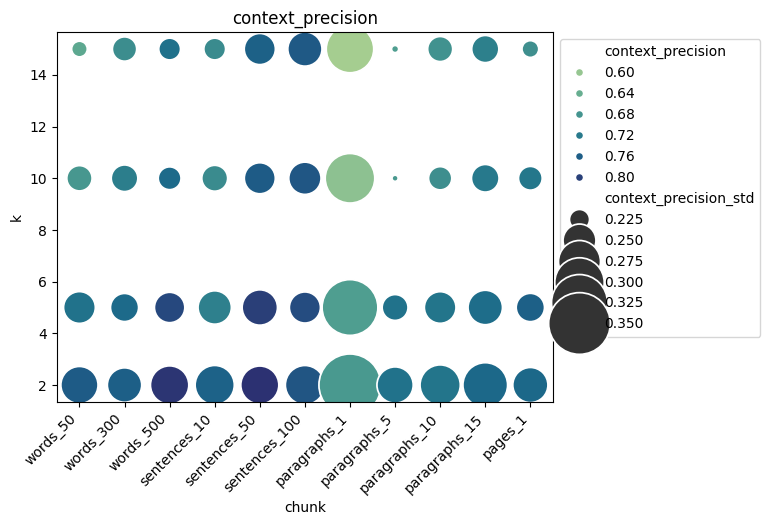

In [71]:
std_scatterplot(df_final,"context_precision")

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


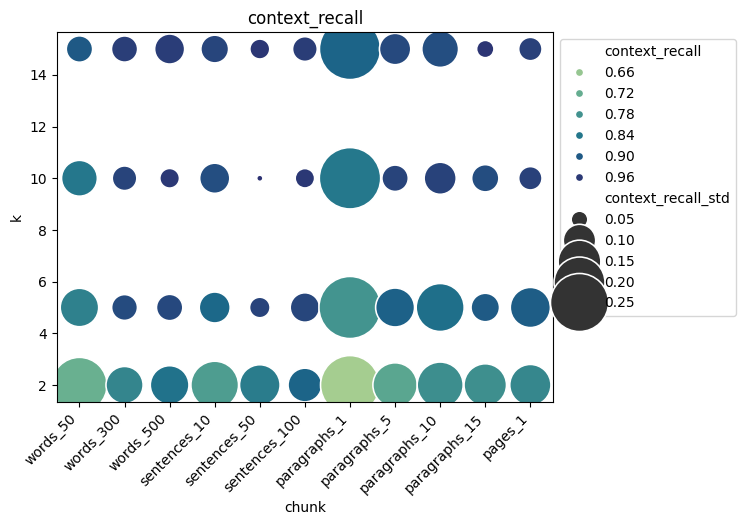

In [72]:
std_scatterplot(df_final,"context_recall")

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


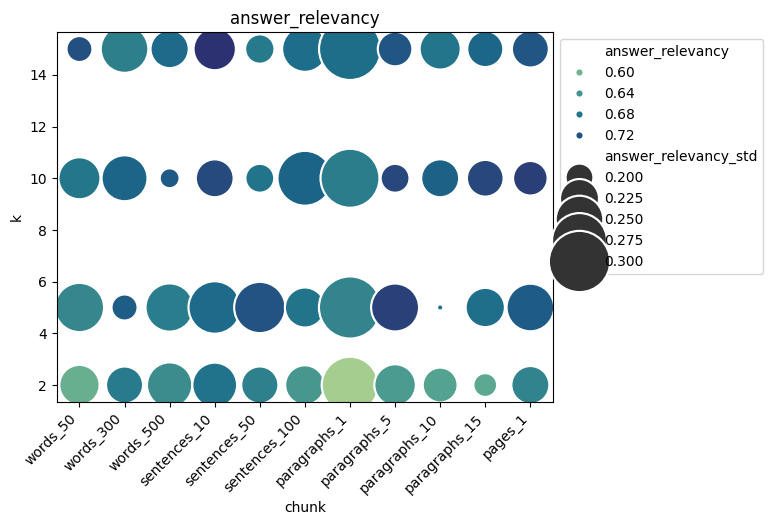

In [73]:
std_scatterplot(df_final,"answer_relevancy")

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


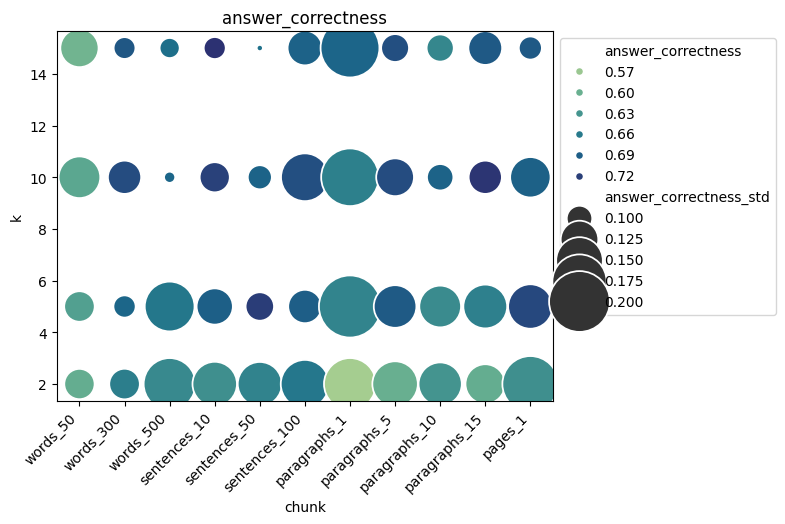

In [74]:
std_scatterplot(df_final,"answer_correctness")

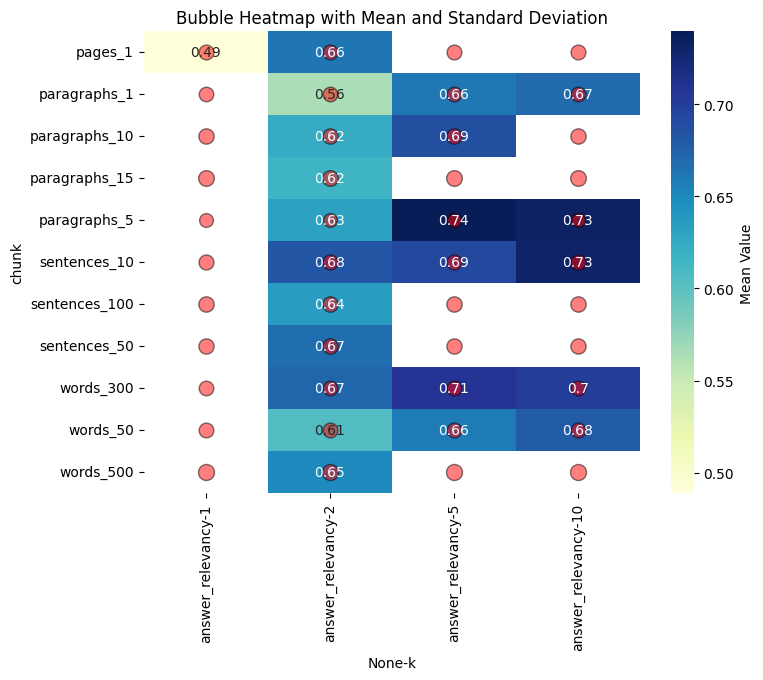

In [23]:
# Plot the heatmap for mean values
plt.figure(figsize=(8, 6))
ax = sns.heatmap(toPlot.pivot(index=["chunk"], columns="k", values=[metric]), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'})

# Overlay bubbles based on standard deviation values (size of bubbles)
for i in range(toPlot[metric].shape[0]):
    for j in range(toPlot["chunk"].shape[0]):
        # You can adjust the bubble size based on the standard deviation value
        ax.scatter(j + 0.5, i + 0.5, s=toPlot[metric_std].iloc[i] * 500, c='red', alpha=0.5, edgecolors='black')

plt.title('Bubble Heatmap with Mean and Standard Deviation')
plt.show()


# Older stuff - heatmap without std

In [30]:
def single_type_heatmap(df, chunk_type = "words", metric = "faithfulness"):
    """Pass in chunk_type and metric as strings from the dataframe columns."""
    toPlot = df[df.chunk_type==chunk_type][["k", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index="k", columns="chunk_size", values=metric), cmap = "crest", annot = True).set_title("Chunk by "+chunk_type)

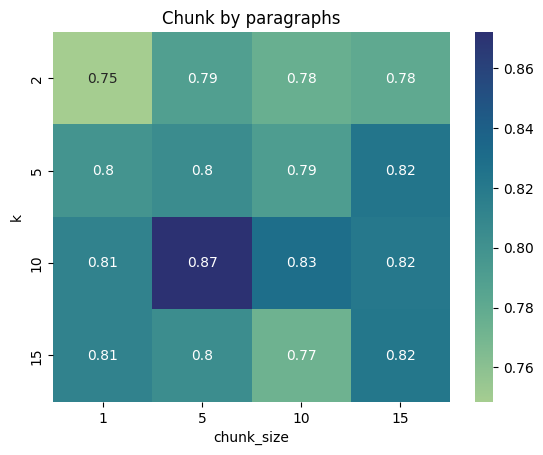

In [31]:
single_type_heatmap(df, "paragraphs", "faithfulness")


In [47]:
def all_chunks_heatmap(df, metric = "faithfulness"):
    toPlot = df[["k", "chunk_type", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index=["chunk_type", "chunk_size"], columns="k", values=metric), cmap = "crest", annot = True).set_title(metric + " by chunks")

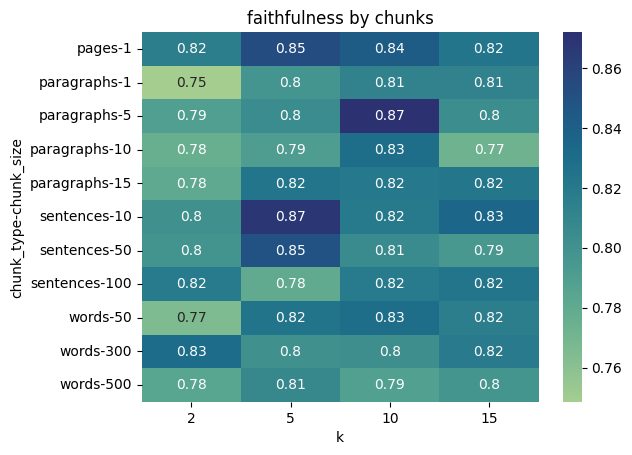

In [48]:
all_chunks_heatmap(df, "faithfulness")

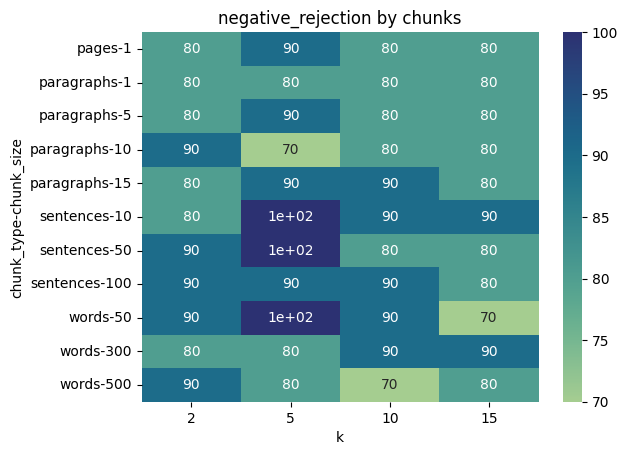

In [49]:
all_chunks_heatmap(df, "negative_rejection")

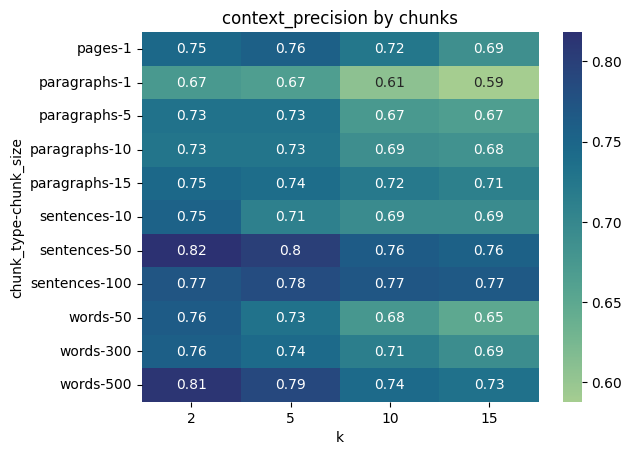

In [50]:
all_chunks_heatmap(df, "context_precision")

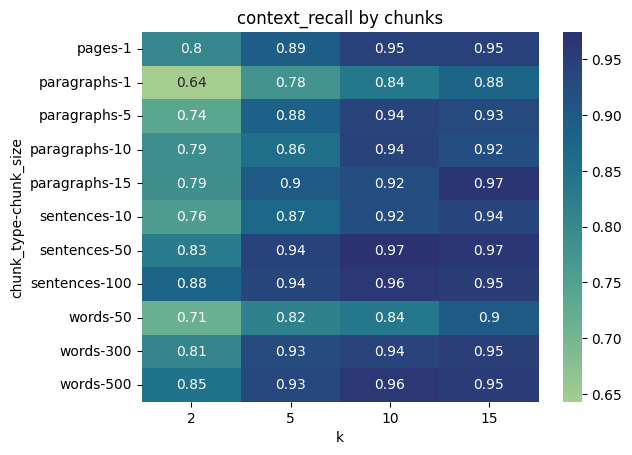

In [52]:
all_chunks_heatmap(df, "context_recall")

In [79]:
import nltk

nltk.download()


2025-04-11 01:04:48.438 Python[49804:1378809] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-11 01:04:48.438 Python[49804:1378809] +[IMKInputSession subclass]: chose IMKInputSession_Modern


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

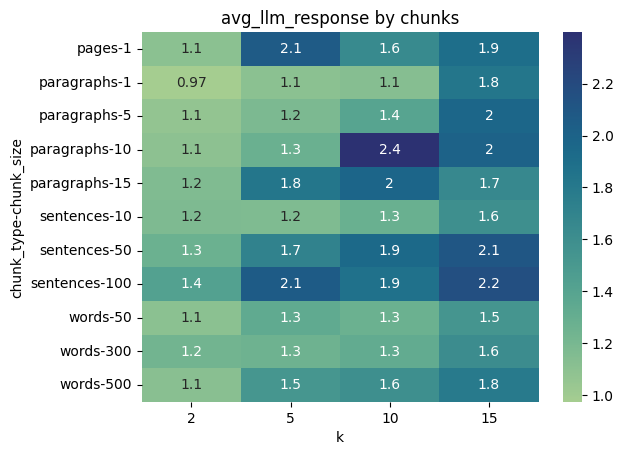

In [53]:
all_chunks_heatmap(df, "avg_llm_response")

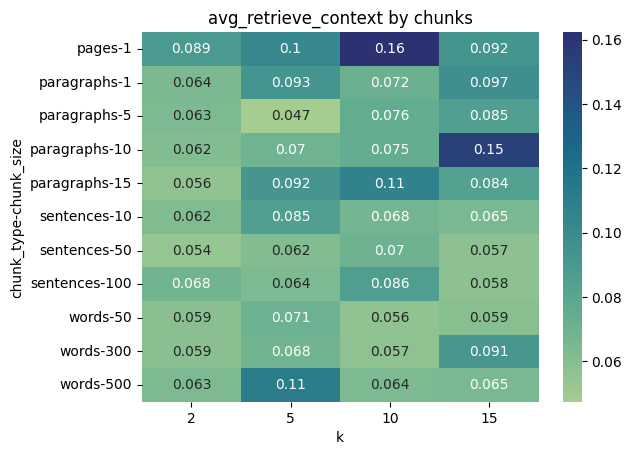

In [54]:
all_chunks_heatmap(df, "avg_retrieve_context")

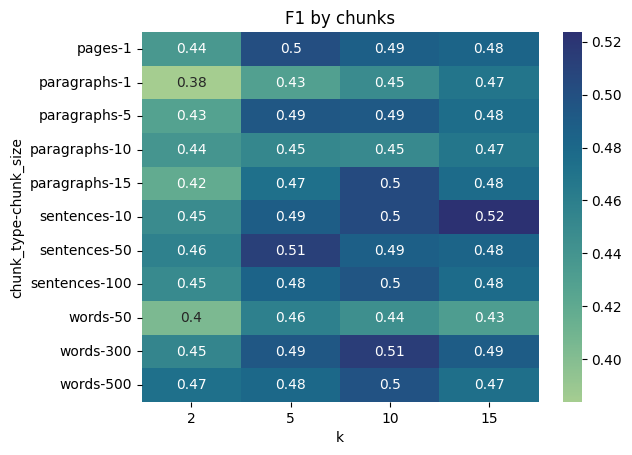

In [55]:
all_chunks_heatmap(df, "F1")

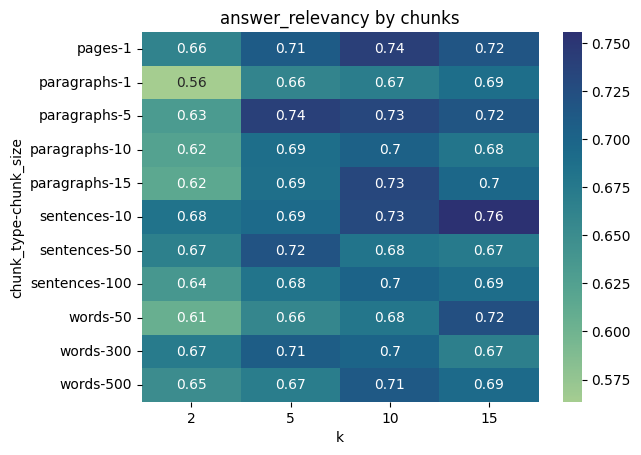

In [56]:
all_chunks_heatmap(df, "answer_relevancy")

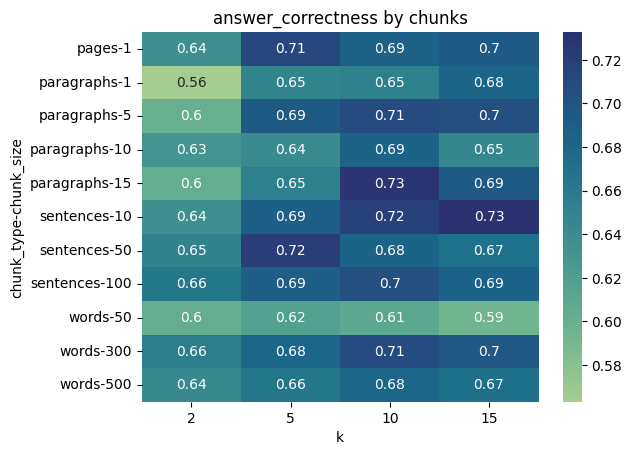

In [57]:
all_chunks_heatmap(df, "answer_correctness")